In [152]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import numpy as np
from scipy import stats

In [153]:
ds = pd.read_csv('./data/processed/TERRACLIMATE_processed.csv')
ds.index = pd.to_datetime(ds.index)
ndvi = pd.read_csv('./data/csv/LANDSAT_NDVI_EVI_ikhnart_v1_long_2019-06-24.csv')
ndvi.index = pd.to_datetime(ndvi.img_date)
ipoints = pd.read_csv('./data/csv/ikhnart_points_v1.csv')

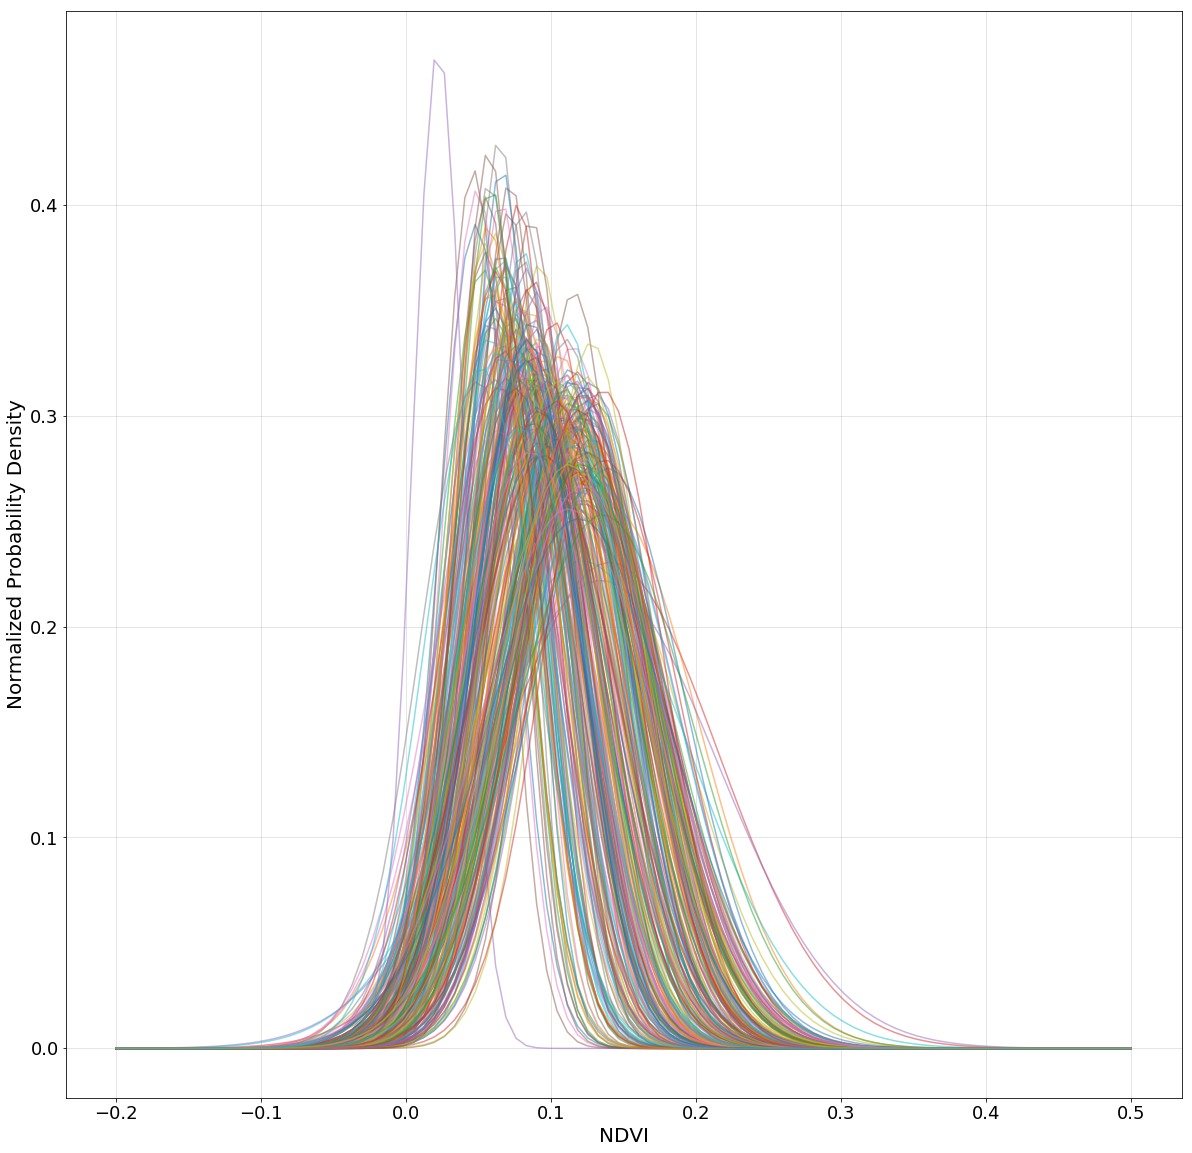

In [154]:
#plot the distribution of ndvis for each point to determine representative samples
pnts = np.unique(ndvi.location)
f, ax = plt.subplots(1,1,figsize=(20,20))
means = np.zeros(len(pnts)) 
stds = np.zeros(len(pnts))
for p in pnts:
    pnt = ndvi[ndvi.location==p]
    m, s = norm.fit(pnt.NDVI)
    means[p] = m
    stds[p] = s
    lnspc = np.linspace(-0.2,0.5,100)
    pdf_norm = norm.pdf(lnspc, m, s)
    #a,b,c = stats.gamma.fit(pnt.NDVI)
    #pdf_gamma = stats.gamma.pdf(lnspc, a,b,c)
    ax.plot(lnspc, pdf_norm/np.linalg.norm(pdf_norm), label='point %s'%p, alpha=0.5)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel('NDVI', fontsize=20)
ax.set_ylabel('Normalized Probability Density', fontsize=20)
ax.grid(alpha=0.4)

In [155]:
#get the 90th percentiles and mean
mu = np.median(means)
sig = np.median(stds)
lower = np.percentile(means, 5)
upper = np.percentile(means, 95)

thr = 0.01
med_pnts = pnts[(means >=mu-thr) & (means <= mu+thr)][:2]
lower_pnts = pnts[(means >=lower-thr) & (means <= lower+thr)][:2]
upper_pnts = pnts[(means >=upper-thr) & (means <= upper+thr)][:2]
rep_pnts = np.array([lower_pnts, med_pnts, upper_pnts]).flatten()
ipoints.iloc[rep_pnts]

,PlotKey,Latitude,Longitude
17,17,45.352316,108.671727
25,25,45.395650,108.748085
13,13,45.555941,108.647882
18,18,45.500710,108.660826
0,0,45.698469,108.639093
3,3,45.793459,108.704411


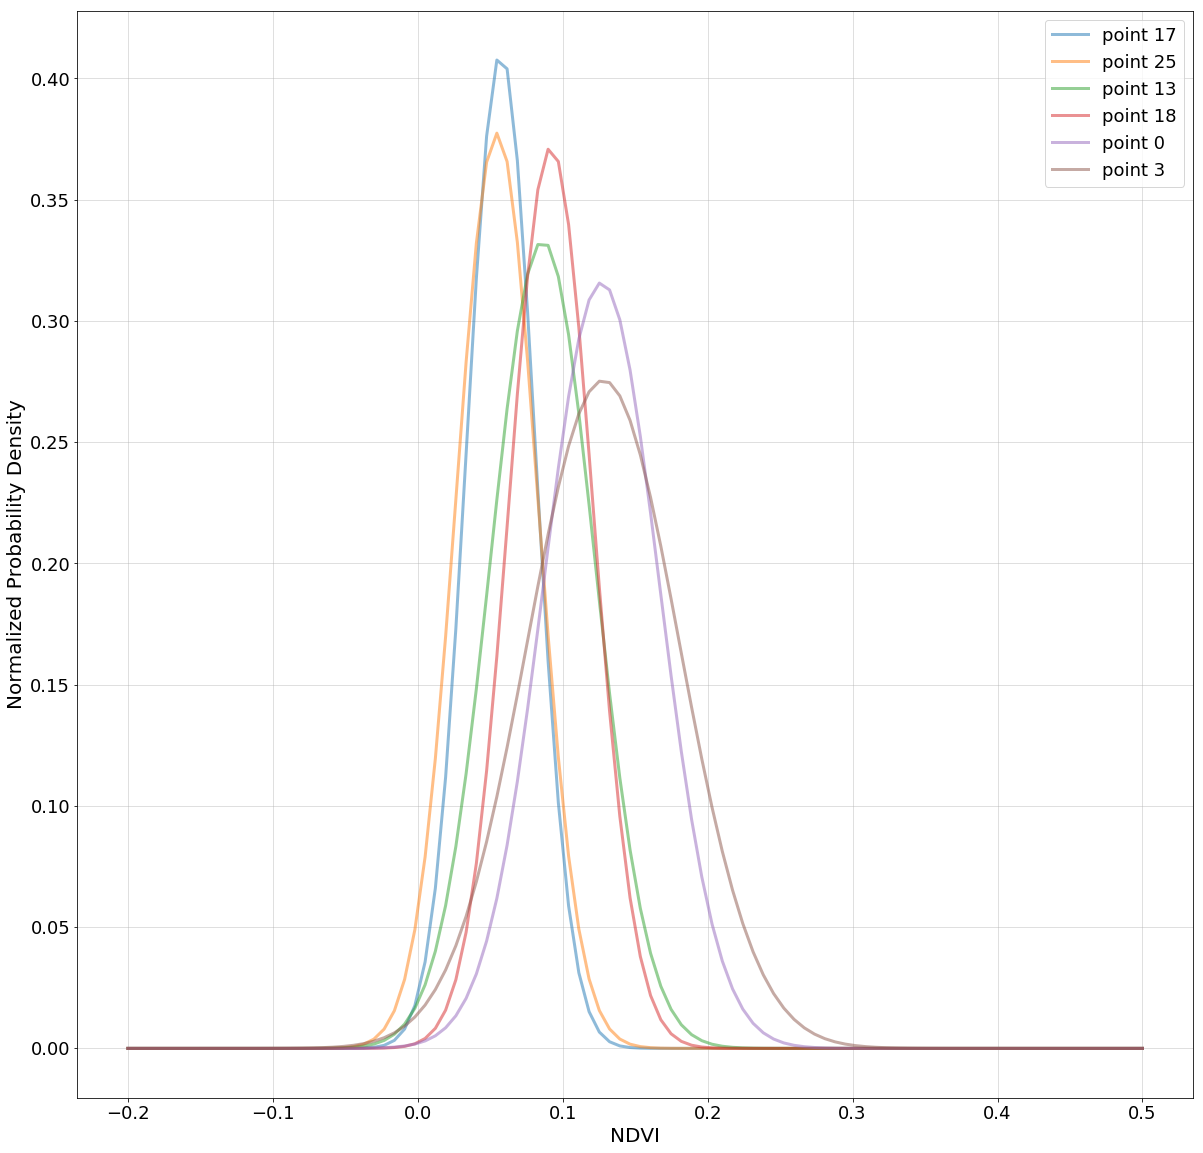

In [156]:
#try ploting again with these points
#plot the distribution of ndvis for each point to determine representative samples
f, ax = plt.subplots(1,1,figsize=(20,20))
for p in rep_pnts:
    pnt = ndvi[ndvi.location==p]
    m, s = norm.fit(pnt.NDVI)
    lnspc = np.linspace(-0.2,0.5,100)
    pdf_norm = norm.pdf(lnspc, m, s)
    #a,b,c = stats.gamma.fit(pnt.NDVI)
    #pdf_gamma = stats.gamma.pdf(lnspc, a,b,c)
    ax.plot(lnspc, pdf_norm/np.linalg.norm(pdf_norm), label='point %s'%p, alpha=0.5, lw=3)
ax.legend(fontsize=18)
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel('NDVI', fontsize=20)
ax.set_ylabel('Normalized Probability Density', fontsize=20)
ax.grid(alpha=0.5)

In [151]:
ipoints.iloc(rep_points)

NameError: name 'rep_points' is not defined

In [215]:
df = ds.groupby(['date']).agg('median')
ndvi_mu = ndvi.groupby(['img_date']).agg('median')
ndvi_mu.index = pd.to_datetime(ndvi_mu.index)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: 'img_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [216]:
'''
x = dsmu.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=dsmu.columns)
df.index = dsmu.index
'''
df.index = pd.to_datetime(df.index)
df = df['19851201':'20190901']

In [222]:
ts ='1m'
ndvi_resample = ndvi_mu.resample(ts).median()
var = 'pdsi'
ndvi_resample['abv'] = ndvi_resample['NDVI']
ndvi_resample['bel'] = ndvi_resample['NDVI']
ndvi_mean = np.mean(ndvi_resample.NDVI)
ndvi_resample.abv[ndvi_resample.abv<ndvi_mean] = ndvi_mean
ndvi_resample.bel[ndvi_resample.bel>ndvi_mean] = ndvi_mean
ndvi_resample.bel[np.isnan(ndvi_resample.bel)] = ndvi_mean
ndvi_resample.abv[np.isnan(ndvi_resample.abv)] = ndvi_mean

climate_resample = df[[var]].resample(ts).median()
climate_resample['abv'] = climate_resample[var]
climate_resample['bel'] = climate_resample[var]
climate_mean = np.mean(climate_resample[var])
climate_resample.abv[climate_resample.abv<climate_mean] = climate_mean
climate_resample.bel[climate_resample.bel>climate_mean] = climate_mean
climate_resample.bel[np.isnan(climate_resample.bel)] = climate_mean
climate_resample.abv[np.isnan(climate_resample.abv)] = climate_mean

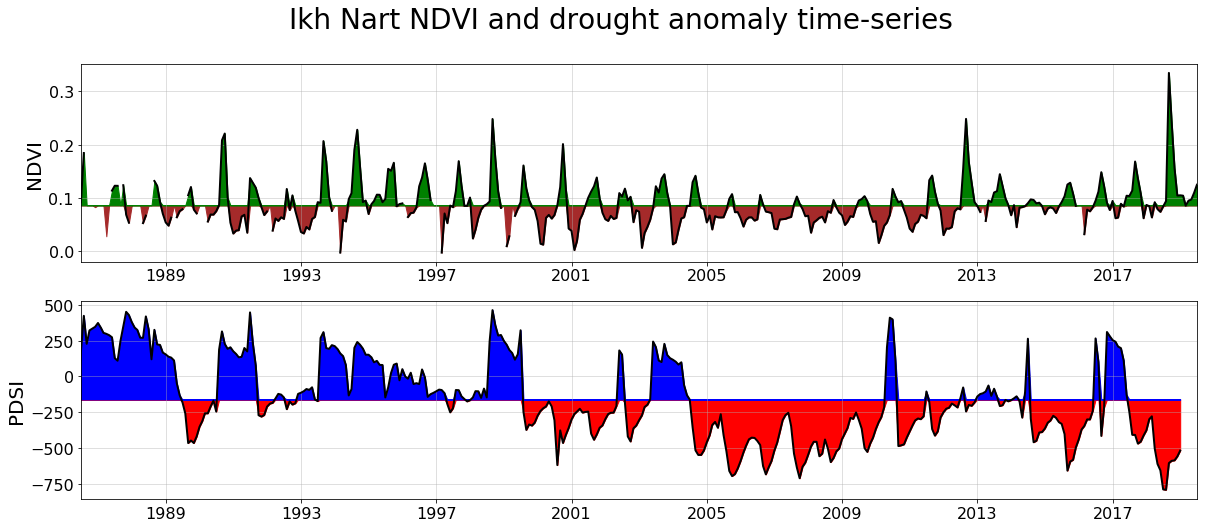

In [226]:
f, ax = plt.subplots(2,1,figsize=(20,8))
ax[0].plot(ndvi_resample.index, ndvi_resample['NDVI'], \
           color='black', lw=2)
ax[1].plot(climate_resample.index, climate_resample[var],\
           color='black', lw=2)
ax[0].fill_between(ndvi_resample.index, \
                   ndvi_mean, \
                   ndvi_resample['bel'], color='brown')
ax[0].fill_between(ndvi_resample.index, \
                   ndvi_mean, \
                   ndvi_resample['abv'], color='green')
ax[0].grid(alpha=0.5)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].set_ylabel('NDVI', fontsize=20)
ax[1].fill_between(climate_resample.index, \
                   climate_mean, \
                   climate_resample['bel'], color='red')
ax[1].fill_between(climate_resample.index, \
                   climate_mean, \
                   climate_resample['abv'], color='blue')

ax[1].grid(alpha=0.5)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].set_ylabel('PDSI', fontsize=20)
ax[0].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
ax[1].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
f.suptitle('Ikh Nart NDVI and drought anomaly time-series',\
          fontsize=28)
f.savefig('./out/ikhnart_NDVI_climate_series.png', dpi=500, bbox_inches='tight')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e41093358>,
      dtype=object)

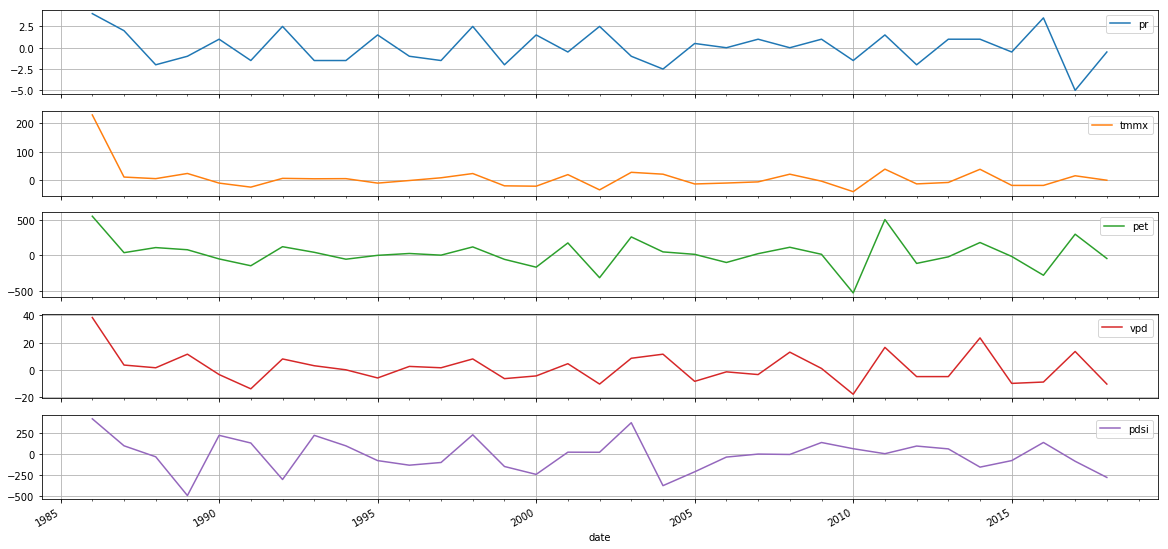

In [228]:
df[['pr','tmmx','pet','vpd','pdsi']].resample('1y').median().diff().plot(subplots=True,figsize=(20,10),\
                                                     grid=True)